In [18]:
import re
import os
import pysolr
import tabulate
from datetime import datetime
from pprint import pprint
from IPython.display import HTML, display

# Render our plots inline
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.family'] = 'sans-serif'

# This is necessary to show lots of columns in pandas 0.12. 
# Not necessary in pandas 0.13.
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)


In [19]:
# Solr collection url 
SOLR_URL = 'http://solr:8983/solr/cmp269'

QUERIES_FILE_PATH = 'data/Consultas_UTF8.txt'

## Código pra ler os arquivos e separar as queries com base nas tags

In [20]:
def parse_file(fpath, doc_tag):
    '''Reads file line by line and extract the docs'''

    docs = []
    closing_doc_line = "</%s>\n" % doc_tag
    
    with open(fpath) as file:
        doc_as_string = ""

        line = file.readline()
        while (line):
            if (line) == closing_doc_line:
                doc_as_string += line
                
                doc = parse_doc(doc_as_string)
                docs.append(doc)

                doc_as_string = ""
            else:
                doc_as_string += line

            line = file.readline()

    return docs

## Código para fazer o parse da string de cada query e criar um dicionário

In [21]:
def parse_doc(doc_as_string):
    # print(doc_as_string)

    doc_tpl = {
        'num': 'num',
        'PT-title': 'title',
        'PT-desc': 'desc',
        'PT-narr': 'narr',
    }

    doc = {}

    for key in doc_tpl.keys():
        # generates something like:
        # str_pattern = ".*\<DOCID\>(.*)\<\/DOCID\>.*"
        str_pattern = ".*\<%s\>(.*)\<\/%s\>.*" % (key, key)

        # compiles pattern, capture match, updates doc
        re_pattern = re.compile(str_pattern, re.DOTALL)
        match = re_pattern.match(doc_as_string)
        
        if match:
            value = match.group(1).strip()
            solr_key = doc_tpl[key]
            doc.update({solr_key: value})

    # ensures we have all keys..
    for key in doc_tpl.values():
        assert(doc[key] is not None)

    return doc


In [22]:
sq = pysolr.Solr(SOLR_URL)

queries = parse_file(QUERIES_FILE_PATH, 'top')

pprint(queries[0])

{'desc': 'Encontrar documentos sobre tratamentos que empreguem medicina '
         'natural ou alternativa. Aqui são incluídas terapias como a '
         'acupuntura, a hemopatia, a quiroprática, entre outras.',
 'narr': 'Documentos relevantes devem fornecer informação, específica ou '
         'genérica, sobre o uso de tratamentos ou técnicas de medicina '
         'natural ou alternativa.',
 'num': '251',
 'title': 'Medicina alternativa'}


## Testando várias maneiras diferentes de fazer a query na API do Solr...

In [23]:
def query(params):
    result = sq.search(**params)
    result_lines.append([result.hits, params])


sq = pysolr.Solr(SOLR_URL)


queries = parse_file(QUERIES_FILE_PATH, 'top')

# Vamos testar só com as duas primeiras
queries = queries[:2]

for q in queries:
    
    result_lines = []
    title = q["title"]

    # query inteira e entre aspas, precedida pelo nome do campo ("text_txt_pt:")
    quoted_query = 'text_txt_pt:"%s"' % title

    # cada termo da query precedido pelo nome do campo
    parts = ["text_txt_pt:%s" % p for p in title.split(' ')]
    unquoted_query = '%s' % ' '.join(parts)

    # cada termo da query precedido por "+text_txt_pt:" (repare o sinal +)
    parts = ["+text_txt_pt:%s" % p for p in title.split(' ')]
    plus_query = '%s' % ' '.join(parts)

    
    # default field
    default_field = "text_txt_pt"
    
    # query inteira e entre aspas (sem o nome do campo)
    quoted_query_df = '"%s"' % title

    # query inteira e sem as aspas
    unquoted_query_df = title

    # cada termo da query precedido só pelo sinal de +
    parts = ["+%s" % p for p in title.split(' ')]
    plus_query_df = '%s' % ' '.join(parts)


    # cabeçalho da tabela
    result_lines.append([None, title])
    result_lines.append(['# Results', 'Parameters'])

    ##
    ## Usando o parâmetro query 
    ##
    query({
        "q": quoted_query
    })

    query({
        "q": unquoted_query,
        "q.op": "OR"
    })
    
    query({
        "q": unquoted_query,
        "q.op": "AND"
    })

    query({
        "q": plus_query
    })


    # linha em branco na tabela
    result_lines.append([None,None])

    ##
    ## Usando filter query
    ##
    query({
        "q": "*:*",
        "fq": quoted_query
    })

    query({
        "q": "*:*",
        "q.op": "OR",
        "fq": unquoted_query,
    })

    query({
        "q": "*:*",
        "q.op": "AND",
        "fq": unquoted_query,
    })

    query({
        "q": "*:*",
        "fq": plus_query,
    })


    # linha em branco na tabela
    result_lines.append([None,None])

    ##
    ## Usando default field
    ##

    query({
        "q": quoted_query_df,
        "df": default_field,
    })

    query({
        "q": unquoted_query_df,
        "q.op": "OR",
        "df": default_field,
    })

    query({
        "q": unquoted_query_df,
        "q.op": "AND",
        "df": default_field,
    })
    
    query({
        "q": plus_query_df,
        "df": default_field,
    })

    display(HTML(tabulate.tabulate(result_lines, tablefmt='html')))

print("The end")

,Medicina alternativa
# Results,Parameters
2,"{'q': 'text_txt_pt:""Medicina alternativa""'}"
2616,"{'q.op': 'OR', 'q': 'text_txt_pt:Medicina text_txt_pt:alternativa'}"
41,"{'q.op': 'AND', 'q': 'text_txt_pt:Medicina text_txt_pt:alternativa'}"
41,{'q': '+text_txt_pt:Medicina +text_txt_pt:alternativa'}
,
2,"{'fq': 'text_txt_pt:""Medicina alternativa""', 'q': '*:*'}"
2616,"{'fq': 'text_txt_pt:Medicina text_txt_pt:alternativa', 'q.op': 'OR', 'q': '*:*'}"
41,"{'fq': 'text_txt_pt:Medicina text_txt_pt:alternativa', 'q.op': 'AND', 'q': '*:*'}"
41,"{'fq': '+text_txt_pt:Medicina +text_txt_pt:alternativa', 'q': '*:*'}"


,Sistemas de reforma e pensões na Europa
# Results,Parameters
0,"{'q': 'text_txt_pt:""Sistemas de reforma e pensões na Europa""'}"
11409,"{'q.op': 'OR', 'q': 'text_txt_pt:Sistemas text_txt_pt:de text_txt_pt:reforma text_txt_pt:e text_txt_pt:pensões text_txt_pt:na text_txt_pt:Europa'}"
0,"{'q.op': 'AND', 'q': 'text_txt_pt:Sistemas text_txt_pt:de text_txt_pt:reforma text_txt_pt:e text_txt_pt:pensões text_txt_pt:na text_txt_pt:Europa'}"
0,{'q': '+text_txt_pt:Sistemas +text_txt_pt:de +text_txt_pt:reforma +text_txt_pt:e +text_txt_pt:pensões +text_txt_pt:na +text_txt_pt:Europa'}
,
0,"{'fq': 'text_txt_pt:""Sistemas de reforma e pensões na Europa""', 'q': '*:*'}"
11409,"{'fq': 'text_txt_pt:Sistemas text_txt_pt:de text_txt_pt:reforma text_txt_pt:e text_txt_pt:pensões text_txt_pt:na text_txt_pt:Europa', 'q.op': 'OR', 'q': '*:*'}"
0,"{'fq': 'text_txt_pt:Sistemas text_txt_pt:de text_txt_pt:reforma text_txt_pt:e text_txt_pt:pensões text_txt_pt:na text_txt_pt:Europa', 'q.op': 'AND', 'q': '*:*'}"
0,"{'fq': '+text_txt_pt:Sistemas +text_txt_pt:de +text_txt_pt:reforma +text_txt_pt:e +text_txt_pt:pensões +text_txt_pt:na +text_txt_pt:Europa', 'q': '*:*'}"


The end


## Escolhendo um jeito...

Dá pra ver que há vários jeitos de fazer a mesma query...
Escolhendo uma das opções que traz pelo menos um resultado ambas as queries:

* Sem aspas
* Usando o operador OR
* Indicando o default_field

Ex:

```python
{
    'df': 'text_txt_pt', 
    'q': 'Centrais nucleares', 
    'q.op': 'OR'
}
```




In [24]:
sq = pysolr.Solr(SOLR_URL)

result_lines = []
result_lines.append(['# Results', 'query'])

queries = parse_file(QUERIES_FILE_PATH, 'top')
for q in queries:

    title = q["title"]

    params = {
        "q": title,
        "q.op": "OR",
        "df": "text_txt_pt",
    }
    
    result = sq.search(**params)
    result_lines.append([result.hits, title])
    
    result = None
    
display(HTML(tabulate.tabulate(result_lines, tablefmt='html')))

print("The end")

# Results,query
2616,Medicina alternativa
11409,Sistemas de reforma e pensões na Europa
10121,Países com pena de morte
1406,Danos provocados por terramotos
964,Viciados na Internet
1218,Doença de Creutzfeldt-Jakob
1209,Limpeza étnica nos Balcãs
1940,Legislação anti-tabagista
12,Adivinhação
2,Espectáculos de beneficiência


The end


##Fazendo a mesma query em campos com pré-processamentos distintos

In [25]:
sq = pysolr.Solr(SOLR_URL)

fields = ['text_txt_c1', 'text_txt_c2', 'text_txt_c3', 'text_txt_c4',
          'text_txt_c5', 'text_txt_c6', 'text_txt_c7',]

cols = ['Query title'] + fields

result_lines = []

queries = parse_file(QUERIES_FILE_PATH, 'top')
for q in queries:
    title = q["title"]
    result_line = [title]
    
    for field in fields:
        params = {
            "q": title,
            "q.op": "OR",
            "df": field,
        }

        result = sq.search(**params)
        result_line.append(result.hits)

    result_lines.append(result_line)
    result = None
    
df = pd.DataFrame(data=result_lines, columns=cols)
df_indexed = df.set_index('Query title')  # indexando pela query

df_indexed

,text_txt_c1,text_txt_c2,text_txt_c3,text_txt_c4,text_txt_c5,text_txt_c6,text_txt_c7
Query title,,,,,,,
Medicina alternativa,1468,1787,1787,2616,2616,2616,2616
Sistemas de reforma e pensões na Europa,52004,52007,6038,11409,11409,14097,14742
Países com pena de morte,51836,51848,8060,10121,10130,10323,10507
Danos provocados por terramotos,36245,37062,518,1406,1459,1612,1614
Viciados na Internet,40495,41554,803,964,964,964,964
Doença de Creutzfeldt-Jakob,51728,51741,827,1218,1218,1218,1218
Limpeza étnica nos Balcãs,18697,19880,771,1209,1209,1210,1741
Legislação anti-tabagista,439,1900,1900,1940,1940,1941,9235
Adivinhação,0,11,11,12,12,12,12


## Calculando a variação entre a maior e a menor quantidade de documentos retornados. O resultado disso é adicionado como uma nova coluna "variation". 

In [26]:
variation_df = df_indexed.copy()
variation_df.loc[:, "variation"] = variation_df.apply(lambda x: np.max(x) - np.min(x), axis=1)
variation_df.sort("variation", ascending=False, inplace=True)
variation_df



,text_txt_c1,text_txt_c2,text_txt_c3,text_txt_c4,text_txt_c5,text_txt_c6,text_txt_c7,variation
Query title,,,,,,,,
Espectáculos de beneficiência,51728,51740,1,2,2,2,2,51739
Doença de Creutzfeldt-Jakob,51728,51741,827,1218,1218,1218,1218,50914
Ética e a Clonagem Humana,51663,51806,1282,3418,3418,3420,3519,50524
Contrabando de material radioativo,51730,51742,1549,2065,2065,2072,2073,50193
Disputas de arbitragem no futebol,51856,51886,1998,3160,3160,3836,3840,49888
Reconstrução de cidades alemãs,51729,51741,2099,9542,9542,15014,15015,49642
Aquisições do Deutsche Bank,49111,49164,287,654,654,662,735,48877
Relações entre a China e a Formosa,51671,51812,2982,8069,8069,14769,14813,48830
Missões do vaivém espacial,49115,49170,342,1061,1061,1063,4775,48828


## Plotando as top queries que tiveram maior variação no número de documentos retornados, considerando o campo com mais e menos registros retornados.

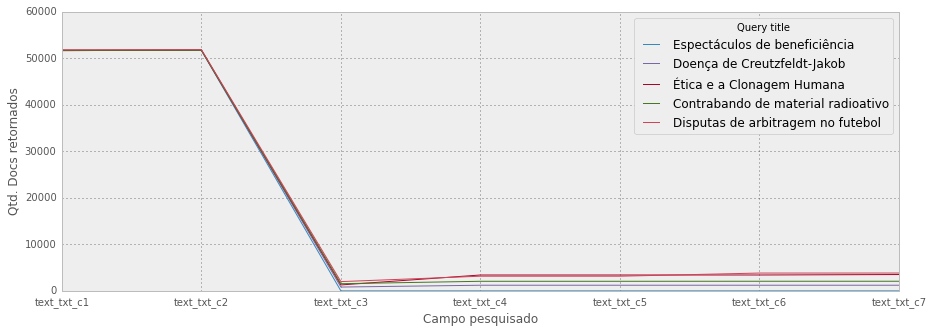

In [27]:
graph = variation_df.head().drop(["variation"], axis=1).T.plot()

graph.set_ylabel("Qtd. Docs retornados")
graph.set_xlabel("Campo pesquisado")

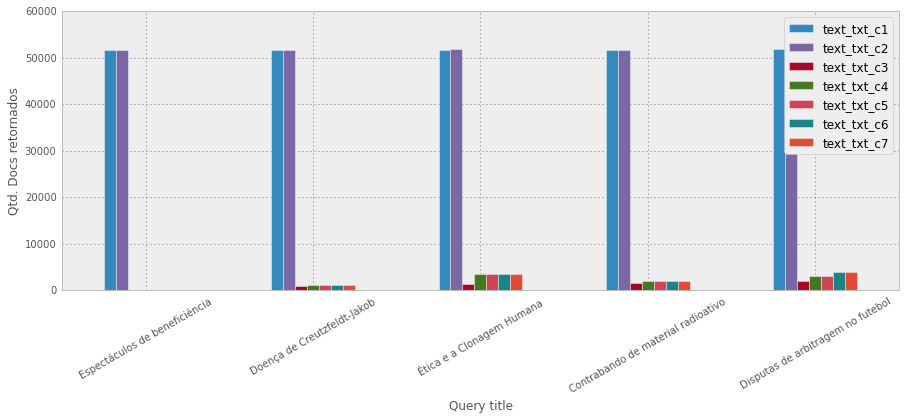

In [28]:
graph = variation_df.head().drop("variation", axis=1).plot(kind='bar', rot=30)

graph.set_ylabel("Qtd. Docs retornados")
graph.set_xlabel("Query title")

## Calculando a variação entre do número de resultados retornados por cada par de campos (ex.: 'retornados ao fazer query no campo text_txt_c1' - 'retornados ao fazer query no campo text_txt_c2') e acumulando esse valor na coluna "pair_variation".

In [29]:
def compute_pair_diff(row):
    fields = ["text_txt_c1", "text_txt_c2", "text_txt_c3","text_txt_c4",
              "text_txt_c5", "text_txt_c6", "text_txt_c7",]
    pair_diff = 0
    for i in range(0,6):        
        pair_diff += abs(row[fields[i]] - row[fields[i+1]])

    return pair_diff

pair_variation_df = variation_df.copy()
pair_variation_df.loc[:, "pair_variation"] = variation_df.apply(compute_pair_diff, axis=1)
pair_variation_df.sort(["pair_variation"], ascending=False, inplace=True)
pair_variation_df



,text_txt_c1,text_txt_c2,text_txt_c3,text_txt_c4,text_txt_c5,text_txt_c6,text_txt_c7,variation,pair_variation
Query title,,,,,,,,,
Filmes da série James Bond,48371,49432,4550,7610,7610,27677,27708,44882,69101
Reconstrução de cidades alemãs,51729,51741,2099,9542,9542,15014,15015,49642,62570
Relações entre a China e a Formosa,51671,51812,2982,8069,8069,14769,14813,48830,60802
Bombas não detonadas da Segunda Guerra Mundial,49754,50381,10087,24389,24390,24626,27953,40294,58787
Sistemas de reforma e pensões na Europa,52004,52007,6038,11409,11409,14097,14742,45969,54676
Missões do vaivém espacial,49115,49170,342,1061,1061,1063,4775,48828,53316
Ética e a Clonagem Humana,51663,51806,1282,3418,3418,3420,3519,50524,52904
Disputas de arbitragem no futebol,51856,51886,1998,3160,3160,3836,3840,49888,51760
Espectáculos de beneficiência,51728,51740,1,2,2,2,2,51739,51752


## Há diferenças entre uma variação e a outra?

In [30]:
pair_variation_df.index != variation_df.index


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False], dtype=bool)

## Plotando as top queries que tiveram maior variação considerados os pares.

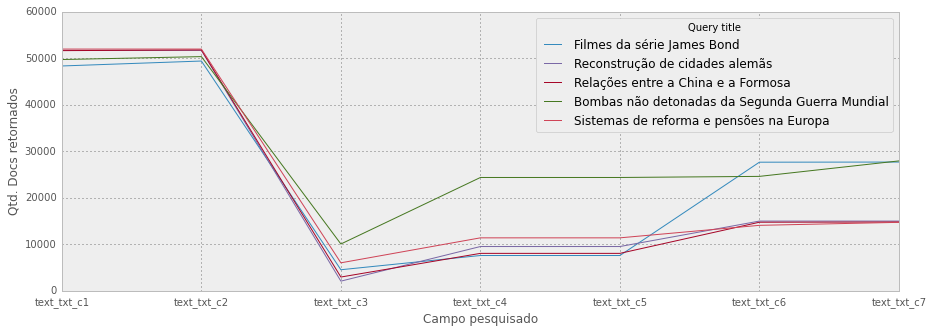

In [31]:
graph = pair_variation_df.head().drop(["variation", "pair_variation"], axis=1).T.plot()

graph.set_ylabel("Qtd. Docs retornados")
graph.set_xlabel("Campo pesquisado")

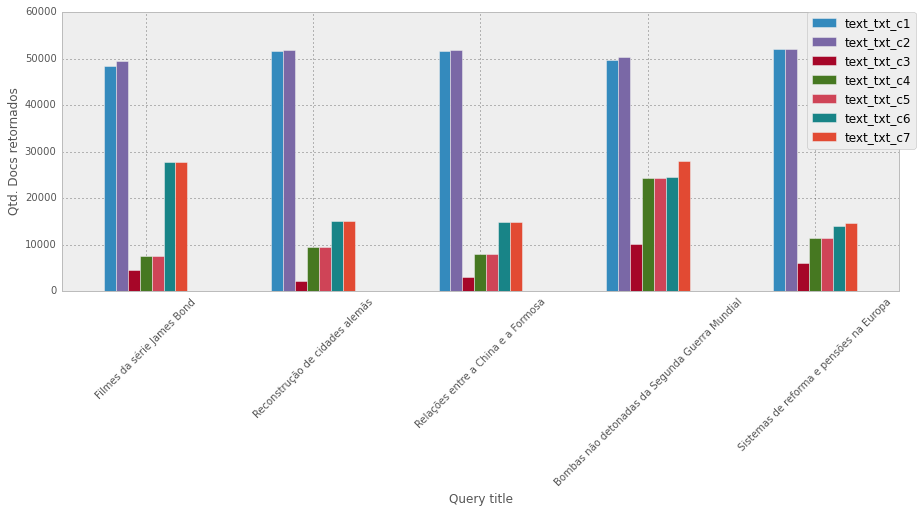

In [32]:
graph = pair_variation_df.head().drop(["variation", "pair_variation"], axis=1).plot(kind='bar', rot=45)

graph.set_ylabel("Qtd. Docs retornados")
graph.set_xlabel("Query title")

graph.legend(bbox_to_anchor=(1.02,1), borderaxespad=0)
